### Libraries

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory as idfd
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

###Downloading datasets from Kaggle to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# mounting google drive



Mounted at /content/drive


In [ ]:

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab/"



In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "boguslawkonefal" # username from the json file
os.environ['KAGGLE_KEY'] = "6c04983dd8f634913f849c162a8f9526" # key from the json file
!kaggle datasets download -d lexset/synthetic-asl-alphabet -p '/content/drive/MyDrive/Colab'


100% 6.57G/6.58G [01:30<00:00, 34.9MB/s]
100% 6.58G/6.58G [01:30<00:00, 78.0MB/s]


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab/synthetic-asl-alphabet.zip" -d "/content/drive/MyDrive/Colab" # unzip file in google dr

### Train and test sets

In [14]:
train_path=r"/content/drive/MyDrive/Colab/Train_Alphabet"
test_path=r"/content/drive/MyDrive/Colab/Test_Alphabet"

In [15]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
input_shape = (128,128,3)

In [16]:
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split = 0.2)

In [17]:
train_gen = data_gen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "rgb",
                                        shuffle=True,
                                        class_mode = "categorical",
                                        subset = "training")

Found 19440 images belonging to 27 classes.


In [18]:
val_gen = data_gen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "rgb",
                                        shuffle=False,
                                        class_mode = "categorical",
                                        subset = "validation")

Found 4860 images belonging to 27 classes.


In [19]:
test_gen = data_gen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "rgb",
                                        shuffle=False,
                                        class_mode = "categorical")

Found 2700 images belonging to 27 classes.


In [20]:
labels = train_gen.class_indices
classes = list(labels.keys())

print(classes)

['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [21]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(128,128,3)))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [23]:
history = model.fit(
      train_gen,
      validation_data=val_gen,
      epochs=5,
      verbose=1,
    )

Epoch 1/5
304/304 [==============================] - 421s 1s/step - loss: 1.5247 - accuracy: 0.5403 - val_loss: 0.3734 - val_accuracy: 0.8879
Epoch 2/5
304/304 [==============================] - 339s 1s/step - loss: 0.2392 - accuracy: 0.9254 - val_loss: 0.1682 - val_accuracy: 0.9457
Epoch 3/5
304/304 [==============================] - 341s 1s/step - loss: 0.0902 - accuracy: 0.9721 - val_loss: 0.1424 - val_accuracy: 0.9574
Epoch 4/5
304/304 [==============================] - 350s 1s/step - loss: 0.0464 - accuracy: 0.9866 - val_loss: 0.1397 - val_accuracy: 0.9599
Epoch 5/5
304/304 [==============================] - 346s 1s/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.1442 - val_accuracy: 0.9636


In [24]:
def plot_hist(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()



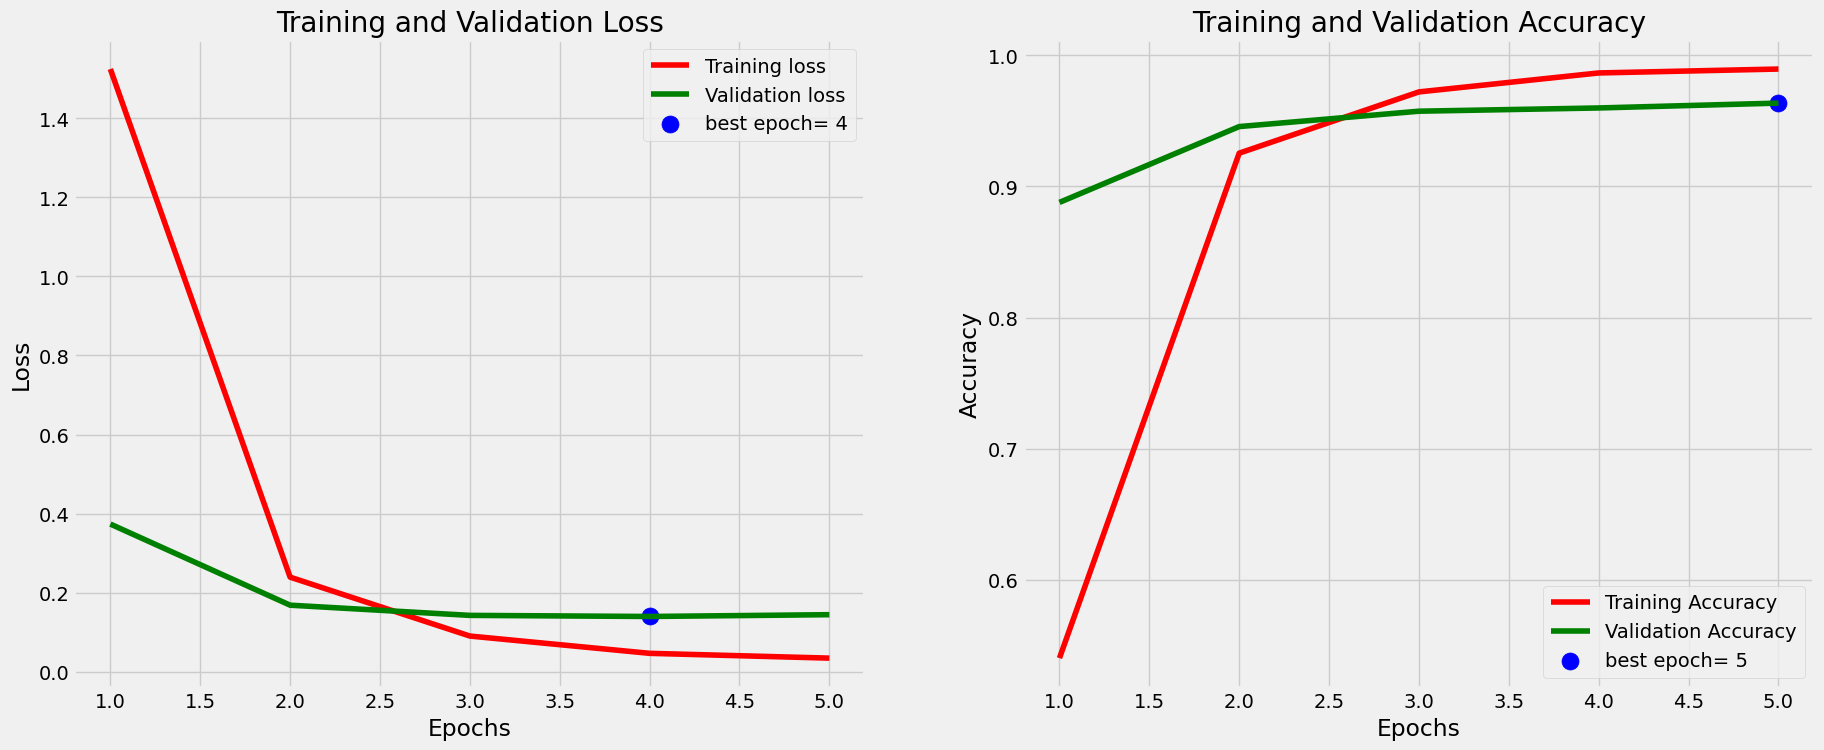

In [25]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

In [26]:
y_pred = model.predict(test_gen,verbose=1)
y_test = test_gen.classes

43/43 [==============================] - 985s 23s/step


In [ ]:
from sklearn.metrics import confusion_matrix
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, 36)

In [ ]:
model.save('ASl.h5')

### Prediction

In [ ]:
test_path = "/content/drive/MyDrive/Colab/Test_Alphabet/X/02583e2f-2539-456d-950f-6629d53b9969.rgb_0000.png"

In [30]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
model = keras.models.load_model('ASL.h5')

In [ ]:
def pipeline(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    data = (np.array(img).reshape(-1,128,128,3))
    pred = model.predict(data)
    return pred[0]

In [ ]:
out = pipeline(test_path)
#print(out)
class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
print(class_names[np.argmax(out)])